In [20]:
import numpy as np
import scipy.fftpack as sf
import scipy.linalg as lp
import pickle
import pywt
import matplotlib.pyplot as plt
import os

### Load Data

In [2]:
data = np.zeros([32,40,40,8064])
labels = np.zeros([32,40,4])

for i in range(1, 33):
    if i < 10:
        file = "./data_preprocessed_python/s{0}.dat".format("0" + str(i))
    else:
        file = "./data_preprocessed_python/s{0}.dat".format(str(i))
    with open(file, 'rb') as f: 
        content = pickle.load(f, encoding= "latin1")
    data[i-1,:,:,:] = content["data"]
    labels[i-1,:,:] = content["labels"]

In [3]:
# 32 subjects that watched 40 videos each with 40 sensors (32 EEG + peripherals) for 60s at 128 Hz
data.shape

(32, 40, 40, 8064)

In [4]:
# 32 subjects that watched 40 videos each that have 4 emotional labels per video
labels.shape

(32, 40, 4)

In [5]:
#segregate into just EEG Data, cut the first 3 seconds that was the baseline (CHECK THIS, waiting on email)
eeg_data = data[:,:,:32,128 * 3:]
eeg_data.shape

(32, 40, 32, 7680)

In [6]:
#split into 6 second intervals. So now 32 individuals who watched 40 videos with 32 EEG sensors and each video is 
#broken up into 10 6 second recording chunks
eeg_data = np.array(np.array_split(eeg_data, 10, axis = 3)).transpose(1,2,3,0,4)
eeg_data.shape

#split into training and test data (TODO in the future)

(32, 40, 32, 10, 768)

### Data Compression

In [7]:
#code source: https://github.com/liubenyuan/pyBSBL/blob/master/bsbl.py
# vector to column (M,1) vector
def v2m(v):
    return v.reshape((v.shape[0],1))

# M = A*B*C
def dot3(A,B,C):
    return np.dot(np.dot(A, B), C)

# ravel list of 'unequal arrays' into a row vector
def ravel_list(d):
    r = np.array([], dtype='int')
    for i in range(d.shape[0]):
        r = np.r_[r,d[i]]
    return r

# extract block spacing information
def block_parse(blk_start_loc, N):
    blk_len_list = np.r_[blk_start_loc[1:], N] - blk_start_loc
    is_equal_block = (np.sum(np.abs(blk_len_list - blk_len_list.mean())) == 0)
    return blk_len_list, is_equal_block

# exploit AR(1) correlation in Covariance matrices
#   r_scale : scale the estimated coefficient
#   r_init : initial guess of r when no-basis is included
#   r_thd : the threshold of r to make the covariance matrix p.s.d
#           the larger the block, the smaller the value
def coeff_r(Cov, gamma, index, r_scale=1.1, r_init=0.90, r_thd=0.999):
    r0 = 0.
    r1 = 0.
    for i in index:
        temp = Cov[i] / gamma[i]
        r0 += temp.trace()
        r1 += temp.trace(offset=1)
    # this method tend to under estimate the correlation
    if np.size(index) == 0:
        r = r_init
    else:
        r = r_scale * r1/(r0 + 1e-8)
    # constrain the Toeplitz matrix to be p.s.d
    if (np.abs(r) >= r_thd):
        r = r_thd * np.sign(r)
    return r

# generate toeplitz matrix
def gen_toeplitz(r,l):
    jup = np.arange(l)
    bs = r**jup
    B = lp.toeplitz(bs)
    return B

#
class bo:
    """
    BSBL-BO : Bound Optimization Algos of BSBL framework
    Recover block sparse signal (1D) exploiting intra-block correlation, 
    given the block partition.
    The algorithm solves the inverse problem for the block sparse
                model with known block partition:
                         y = X * w + v
    Variables
    ---------
    X : array, shape = (n_samples, n_features)
          Training vectors.
    y : array, shape = (n_samples)
        Target values for training vectors
    w : array, shape = (n_features)
        sparse/block sparse weight vector
    Parameters
    ----------
    'learn_lambda' : (1) if (SNR<10dB), learn_lambda=1
                     (2) if (SNR>10dB), learn_lambda=2
                     (3) if noiseless, learn_lambda=0
                     [ Default value: learn_lambda=2 ]
    'lambda_init'  : initial guess of the noise variance
                     [ Default value: lambda_init=1e-2 ]
    'r_init'       : initial value for correlation coefficient
                     [ Default value: 0.90 ]
    'epsilon'      : convergence criterion
    'max_iters'    : Maximum number of iterations.
                     [ Default value: max_iters = 500 ]
    'verbose'      : print debuging information
    'prune_gamma'  : threshold to prune out small gamma_i
                     (generally, 10^{-3} or 10^{-2})
    'learn_type'   : learn_type = 0: Ignore intra-block correlation
                     learn_type = 1: Exploit intra-block correlation
                     [ Default: learn_type = 1 ]
    """

    # constructor
    def __init__(self, learn_lambda=2, lambda_init=1e-2, r_init=0.90,
                  epsilon=1e-8, max_iters=500, verbose=0,
                  learn_type=1, prune_gamma=1e-2):
        self.learn_lambda = learn_lambda
        self.lamb = lambda_init
        self.r_init = r_init
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.learn_type = learn_type
        self.prune_gamma = prune_gamma

    # fit y
    def fit_transform(self, X, y, blk_start_loc=None):
        #
        self.scale = y.std()
        y = y / self.scale
        M, N = X.shape
        # automatically set block partition
        if blk_start_loc==None:
            blkLen = int(N/16.)
            blk_start_loc = np.arange(0,N,blkLen)
        blk_len_list, self.is_equal_block = block_parse(blk_start_loc, N)
        # init variables
        nblock      = blk_start_loc.shape[0]
        self.nblock = nblock
        w           = np.zeros(N,dtype='float')
        Sigma0      = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Sigma_w     = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Cov_x       = [np.identity(blk_len_list[i]) for i in range(nblock)]
        B           = [np.identity(blk_len_list[i]) for i in range(nblock)]
        invB        = [np.identity(blk_len_list[i]) for i in range(nblock)]
        block_slice = np.array([blk_start_loc[i] + np.arange(blk_len_list[i]) for i in range(nblock)])
        gamma       = np.ones(nblock, dtype='float')
        HX          = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Hy          = [np.zeros(blk_len_list[i]) for i in range(nblock)]
        # loops
        for count in range(self.max_iters):
            # prune weights as their hyperparameter goes to zero
            # index -- 0:unused, 1:used
            index = np.argwhere(gamma > self.prune_gamma).ravel()
            # calculate XBX^T
            XBX = np.zeros((M,M), dtype=float)
            for i in index:
                Xi = X[:, block_slice[i]]
                XBX += np.dot(np.dot(Xi, Sigma0[i]), Xi.T)
            invXBX = lp.inv(XBX + self.lamb * np.identity(M))
            #
            for i in index:
                Xi = X[:, block_slice[i]]
                Hi = np.dot(Xi.T, invXBX)
                Hy[i] = np.dot(Hi, y)
                HX[i] = np.dot(Hi, Xi)
            # now we update basis
            w_old = w.copy()
            for i in index:
                seg = block_slice[i]
                w[seg] = np.dot(Sigma0[i], Hy[i])
                Sigma_w[i] = Sigma0[i] - np.dot(np.dot(Sigma0[i], HX[i]), Sigma0[i])
                mu_v = v2m(w[seg])
                Cov_x[i] = Sigma_w[i] + np.dot(mu_v, mu_v.T)

            #=========== Learn correlation structure in blocks ===========
            # 0: do not consider correlation structure in each block
            # 1: constrain all the blocks have the same correlation structure
            if self.learn_type == 1:
                r = coeff_r(Cov_x, gamma, index, r_init=self.r_init)
                if self.is_equal_block:
                    jup = np.arange(Cov_x[0].shape[0])
                    bs = r**jup
                    B0 = lp.toeplitz(bs)
                    invB0 = lp.inv(B0)
                    for i in index:
                        B[i] = B0
                        invB[i] = invB0
                else:
                    for i in index:
                        jup = np.arange(B[i].shape[0])
                        bs = r**jup
                        B[i] = lp.toeplitz(bs)
                        invB[i] = lp.inv(B[i])

            # estimate gammas
            gamma_old = gamma.copy()
            for i in index:
                denom = np.sqrt(np.dot(HX[i], B[i]).trace())
                gamma[i] = gamma_old[i] * lp.norm(np.dot(lp.sqrtm(B[i]), Hy[i])) / denom
                Sigma0[i] = B[i] * gamma[i]
            # estimate lambda
            if self.learn_lambda == 1:
                lambComp = 0.
                for i in index:
                    Xi = X[:,block_slice[i]];
                    lambComp += np.dot(np.dot(Xi, Sigma_w[i]), Xi.T).trace()
                self.lamb = lp.norm(y - np.dot(X, w))**2./N + lambComp/N;
            elif self.learn_lambda == 2:
                lambComp = 0.
                for i in index:
                    lambComp += np.dot(Sigma_w[i], invB[i]).trace() / gamma_old[i]
                self.lamb = lp.norm(y - np.dot(X, w))**2./N + self.lamb * (w.size - lambComp)/N

            #================= Check stopping conditions, eyc. ==============
            dmu = (np.abs(w_old - w)).max(0); # only SMV currently
            if (dmu < self.epsilon):
                break
            if (count >= self.max_iters):
                break
        # exit
        self.count = count + 1
        self.gamma = gamma
        self.index = index
        # let's convert the backyard:
        w_ret = np.zeros(N)
        relevant_slice = ravel_list(block_slice[index])
        w_ret[relevant_slice] = w[relevant_slice]
        return w_ret * self.scale

In [8]:
x = eeg_data[0,0,0,6,:] #test sample

In [9]:
#compression (1/4 original size)
M = 192
N = 768
p = 15/M

np.random.seed(3)
Phi = np.random.binomial(1, p, size = (M,N))

y = np.dot(Phi, x) #compressed data, y = Phi*x

In [10]:
#reconstruction:
#discrete cosine transform as dictionary (D) basis
#step 1: recover signal's coefficients in dct domain
A = np.zeros([M,N],dtype='float')
for k in range(M):
    dct_k = sf.dct(Phi[k,:].astype('float'),norm='ortho')
    A[k,:] = dct_k.copy()

clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)
rev_dct_coeff = clf.fit_transform(A, y)

#step 2: recover the signal using the DCT ceofficients and the DCT basis
x2 = sf.idct(rev_dct_coeff, norm='ortho')

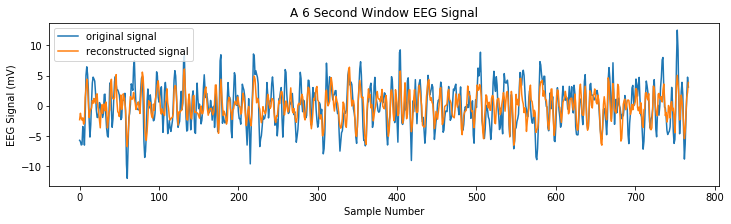

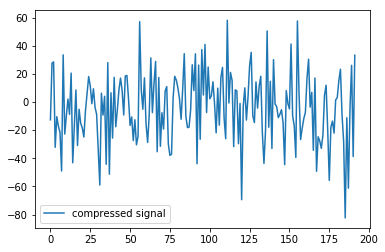

In [11]:
plt.figure(figsize=(12,3))
plt.plot(x, label='original signal')
plt.plot(x2, label='reconstructed signal')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal")
plt.legend()

plt.figure()
plt.plot(y, label='compressed signal')
plt.legend()

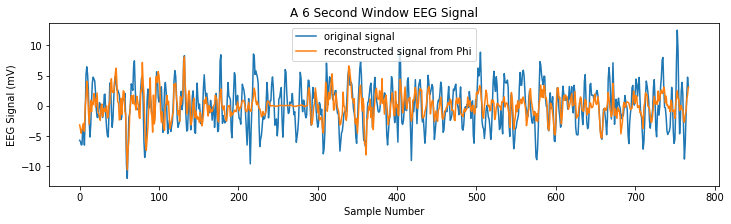

In [12]:
#reconstruction from just Phi?:
clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)
x3 = clf.fit_transform(Phi, y)

plt.figure(figsize=(12,3))
plt.plot(x, label='original signal')
plt.plot(x3, label='reconstructed signal from Phi')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");
plt.legend()

In [13]:
mse_1 = 10*np.log10((lp.norm(x - x2)**2)/lp.norm(x)**2)
mse_2 = 10*np.log10((lp.norm(x - x3)**2)/lp.norm(x)**2)
print(mse_1, mse_2)

-2.8345593517792764 -1.8924521454552792


### Complete Compressive Sensing

In [14]:
M = 192
N = 768
p = 15/M

np.random.seed(3)
Phi = np.random.binomial(1, p, size = (M,N))

size = list(eeg_data.shape[0:4])
size.append(M)
y_all = np.zeros(tuple(size))

In [15]:
y_all.shape, eeg_data.shape

((32, 40, 32, 10, 192), (32, 40, 32, 10, 768))

In [16]:
from datetime import datetime

In [17]:
start1 = datetime.now()
print('start compressing at '+start1.strftime("%H:%M:%S"))

for ind in range(eeg_data.shape[0]): 
    for vid in range(eeg_data.shape[1]):
        for sensor in range(eeg_data.shape[2]):
            for recording in range(eeg_data.shape[3]):
                x = eeg_data[ind,vid,sensor,recording,:]
                y_all[ind,vid,sensor,recording] = np.dot(Phi, x)

end1 = datetime.now()
print('end compressing at '+end1.strftime("%H:%M:%S"))

start compressing at 14:18:51
end compressing at 14:20:04


### Complete Signal Reconstruction

In [18]:
x_reconstructed = np.zeros(np.shape(eeg_data))

In [ ]:
'''
#reconstruction:
#discrete cosine transform as dictionary (D) basis
#step 1: recover signal's coefficients in dct domain
A = np.zeros([M,N],dtype='float')
for k in range(M):
    dct_k = sf.dct(Phi[k,:].astype('float'),norm='ortho')
    A[k,:] = dct_k.copy()

clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)

start2 = datetime.now()
print('start reconstruction at '+start2.strftime("%H:%M:%S"))

for ind in range(eeg_data.shape[0]): 
    print("time "+datetime.now().strftime("%H:%M:%S"))
    print("starting individual "+str(ind))
    for vid in range(eeg_data.shape[1]):
        print("starting video "+str(vid))
        for sensor in range(eeg_data.shape[2]):
            print("starting sensor "+str(sensor))
            for recording in range(eeg_data.shape[3]):
                y = y_all[ind,vid,sensor,recording,:]
                rev_dct_coeff = clf.fit_transform(A, y)

                #step 2: recover the signal using the DCT ceofficients and the DCT basis
                x_reconstructed[ind,vid,sensor,recording] = sf.idct(rev_dct_coeff, norm='ortho')
                

end2 = datetime.now()
print('end reconstruction at '+end2.strftime("%H:%M:%S"))
'''

**Load reconstructed signal**

In [22]:
#load reconstructed signal from files
for i in range(x_reconstructed.shape[0]):
    filepath = os.path.join(os.getcwd(),'reconstructedData','ind'+str(i)+'.npy')
    ind_signal = np.load(filepath) #load individual's signal from file
    x_reconstructed[i] = ind_signal

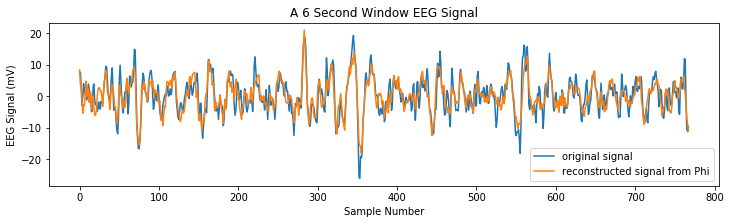

In [25]:
#check with random signal
plt.figure(figsize=(12,3))
plt.plot(eeg_data[7,10,22,5,:], label='original signal')
plt.plot(x_reconstructed[7,10,22,5,:], label='reconstructed signal from Phi')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");
plt.legend()

### Check features of compressed data

**Load compressed data**:

In [27]:
#load compressed signal from file (just to be 100% sure it pairs with the reconstruction)
y_compressed = np.zeros(np.shape(y_all))
for i in range(x_reconstructed.shape[0]):
    filepath = os.path.join(os.getcwd(),'compressedData','ind'+str(i)+'.npy')
    ind_signal = np.load(filepath) #load individual's signal from file
    y_compressed[i] = ind_signal

In [65]:
def calculate_frequency_band_powers(data):
    ps = np.log(np.abs(np.fft.fft(data))**2)
    plt.plot(ps[0])
    time_step = 1 / 128
    freqs = np.fft.fftfreq(data.size, time_step)
    print(ps.shape, freqs.shape)
    print(ps[(freqs >= 4) & (freqs <= 7)])
    theta = np.average(ps[(freqs >= 4) & (freqs <= 7)])
    alpha = np.average(ps[(freqs >= 8) & (freqs <= 13)])
    beta = np.average(ps[(freqs >= 14) & (freqs <= 30)])
    gamma = np.average(ps[(freqs >= 30) & (freqs <= 47)])
    
    return [theta, alpha, beta, gamma]
    

def encode_feature_vector(data):
    feature_vector = []
    for channel in range(32):
        channel_data = data[channel,:]
        print(data.shape)
        print(channel_data.shape)
        frequency_band_powers = calculate_frequency_band_powers(channel_data)
        feature_vector.extend(frequency_band_powers)

    left_channels = list(range(0,14))
    right_channels = [16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31]
    for left_channel,right_channel in zip(left_channels, right_channels):
        left_channel_powers = calculate_frequency_band_powers(data[left_channel,:])
        right_channel_powers = calculate_frequency_band_powers(data[right_channel,:])
        asymmetry_fn = lambda x,y: (x-y)/(x+y)
        aymmetries = [asymmetry_fn(rc,lc) for rc, lc in zip(right_channel_powers, left_channel_powers)]
        feature_vector.extend(aymmetries)
        
    return feature_vector

In [66]:
y_compressed.shape, y_compressed[0,0,:,:].shape

((32, 40, 32, 10, 192), (32, 10, 192))

In [69]:
#feature_matrix = np.zeros(shape = (1280, 184)) #32 individuals who watched 40 videos = 1280
#for ind in range(32):
#    for video in range(40):
#        feature_matrix[(40 * ind) + video,:] = encode_feature_vector(y_compressed[ind, video,:,:])

### Check features of reconstructed data

In [ ]:
#metrics for compressive sensing (used to measure the quality of signal reconstruction and amount of compression):
#compression ratio (CR = n/m)
#percentage root-mean-squared difference (PRD)
#signal to noise and distortion ratio (SNDR)
#percentage sparsity (PS)